Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_diagram
from sklearn.datasets import make_circles
import pickle
import os

Конфиг построений

In [2]:
CONFIG = {
    'homology_dims': (0, 1),
    'results_dir': 'giotto_results',
    'visualization': {
        'style': 'whitegrid',
        'palette': 'muted',
        'figsize': (12, 6)
    }
}

CONFIG.update({
    'data_dims': 5,  # Исходная размерность данных
    'proj_method': 'pca',  # pca, tsne, или None
    'max_viz_dims': 3  # Максимум 3 для 3D-визуализации
})

for dir_path in [CONFIG['results_dir'], 'visualizations']:
    os.makedirs(dir_path, exist_ok=True)

Подготовка данных

In [2]:
with open("data/word2vec_vectors.pkl", "rb") as f:
    word2vec_vectors = pickle.load(f)

In [3]:
vectors = np.array(list(word2vec_vectors.values())) 

Визулизация изначальных данных

In [5]:
def visualize_high_d(data, title_suffix):
    """Универсальная визуализация для любых размерностей"""
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # Проекция данных
    if data.shape[1] > CONFIG['max_viz_dims']:
        if CONFIG['proj_method'] == 'pca':
            proj = PCA(n_components=2).fit_transform(data)
            label = 'PCA проекция'
        elif CONFIG['proj_method'] == 'tsne':
            proj = TSNE(n_components=2).fit_transform(data)
            label = 't-SNE проекция'
        else:
            raise ValueError("Неверный метод проекции")
    else:
        proj = data
        label = 'Исходные данные'
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    
    if proj.shape[1] == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.subplot(111, projection='3d')
        ax.scatter(
            proj[:, 0], 
            proj[:, 1], 
            proj[:, 2],
            c=sns.color_palette("hsv", proj.shape[0]),
            s=40
        )
    else:
        sns.scatterplot(
            x=proj[:, 0],
            y=proj[:, 1],
            hue=np.linalg.norm(data, axis=1),
            palette='viridis',
            s=50
        )
    
    plt.title(f'{label} | {title_suffix}')
    plt.savefig(f"visualizations/{title_suffix}.png", dpi=150)
    plt.close()

In [6]:
visualize_high_d(vectors, 'Исходные данные')

Построение комплекса

In [7]:
def compute_persistence(data):
    """Вычисляет персистентные гомологии с очисткой памяти"""
    homology = VietorisRipsPersistence(
        homology_dimensions=CONFIG['homology_dims'],
        collapse_edges=True,
        n_jobs=-1,
        metric="cosine"
    )
    
    # Преобразование в формат [n_samples, n_points, n_features]
    reshaped_data = data.reshape(1, *data.shape)
    persistence = homology.fit_transform(reshaped_data)
    return persistence[0]

persistence_diagrams = compute_persistence(vectors)

Функции визулизации

In [8]:
def plot_dimension_persistence(persistence_data):
    """Строит и сохраняет отдельные диаграммы для каждой размерности"""
    df = pd.DataFrame(persistence_data, columns=['birth', 'death', 'dim'])
    df['dim'] = df['dim'].astype(int)
    
    # Параметры стиля
    plot_style = {
        'size': 40,
        'edgecolor': 'black',
        'alpha': 0.7
    }
    
    # Создаем отдельный график для каждой размерности
    for dim in CONFIG['homology_dims']:
        dim_data = df[df['dim'] == dim]
        if dim_data.empty:
            continue
            
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=dim_data,
            x='birth',
            y='death',
            hue='dim',
            s=plot_style['size'],
            edgecolor=plot_style['edgecolor'],
            alpha=plot_style['alpha'],
            legend=False
        )
        
        # Линия диагонали и аннотации
        max_val = max(dim_data[['birth', 'death']].max().max(), 1.0)
        plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
        plt.title(f'Персистентная диаграмма (Размерность {dim})')
        plt.xlabel('Время рождения')
        plt.ylabel('Время смерти')
        
        # Сохранение в отдельный файл
        plt.savefig(f"visualizations/persistence_dim_{dim}.png", dpi=150)
        plt.close()

In [9]:
def plot_tda_results(data, suffix):
    """Универсальная функция визуализации"""
    sns.set_style(CONFIG['visualization']['style'])
    plt.figure(figsize=CONFIG['visualization']['figsize'])
    
    if suffix == 'barcode':
        df = pd.DataFrame(persistence_diagrams, columns=['birth', 'death', 'dim'])
        df = df[df['dim'] <= max(CONFIG['homology_dims'])]
        
        for dim in CONFIG['homology_dims']:
            dim_df = df[df['dim'] == dim]
            plt.plot(
                [dim_df['birth'], dim_df['death']],
                [np.arange(len(dim_df))]*2,
                color=sns.color_palette()[dim]
            )
            
        plt.title('Персистентные баркоды')
        plt.xlabel('Значение фильтрации')
        
    elif suffix == 'persistence':
        sns.scatterplot(
            x=persistence_diagrams[:, 0],
            y=persistence_diagrams[:, 1],
            hue=persistence_diagrams[:, 2],
            palette=CONFIG['visualization']['palette']
        )
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('Персистентная диаграмма')

    plt.savefig(f"visualizations/{suffix}.png", bbox_inches='tight')
    plt.close()

Визуализация данных

In [10]:
visualize_high_d(vectors, 'Исходные данные')

Визулизация результатов

In [11]:
visualize_high_d(persistence_diagrams[:, :2], 'Персистентные признаки')
plot_dimension_persistence(persistence_diagrams)

In [12]:
plot_tda_results(persistence_diagrams, 'barcode')
plot_tda_results(persistence_diagrams, 'persistence')

Использование GUDHI

Пример из документации

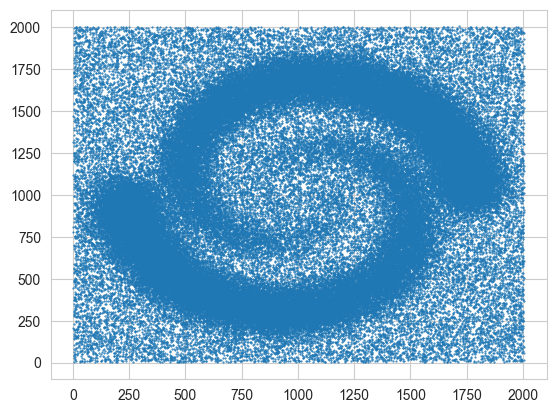

In [13]:
from gudhi.datasets.remote import fetch_spiral_2d
data = fetch_spiral_2d()
plt.scatter(data[:,0],data[:,1],marker='.',s=1)
plt.show()

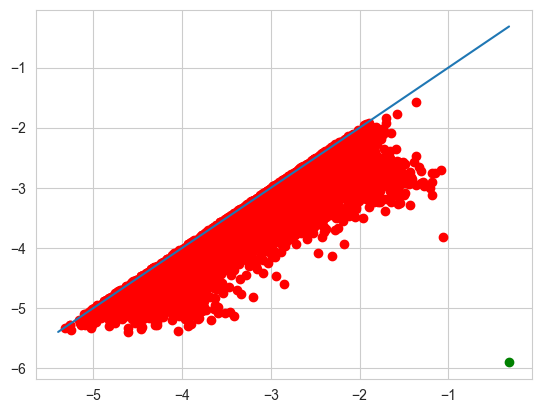

In [14]:
from gudhi.clustering.tomato import Tomato
t = Tomato()
t.fit(data)
t.plot_diagram()

Кластеризация ToMATo

In [4]:
data = vectors

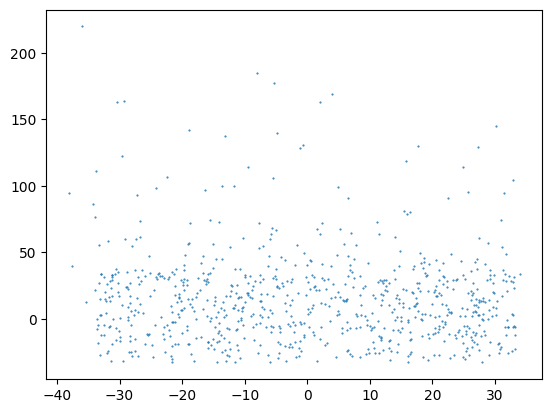

In [10]:
plt.scatter(data[:,0],data[:,1],marker='.',s=1)
plt.show()

In [43]:
from gudhi.clustering.tomato import Tomato
from scipy.spatial.distance import cosine


clusterization = Tomato(metric=cosine, density_type='KDE', k=2, kde_params={'algorithm': 'ball_tree', 'metric': 'pyfunc', 'metric_params': {'func': cosine}})
clusterization.fit(data)

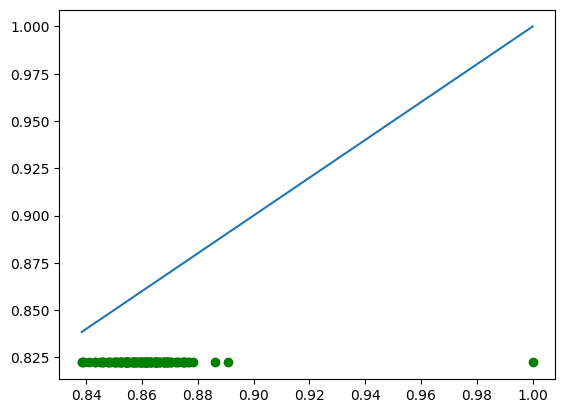

In [44]:
clusterization.plot_diagram()

In [45]:
clusterization.n_clusters_

111

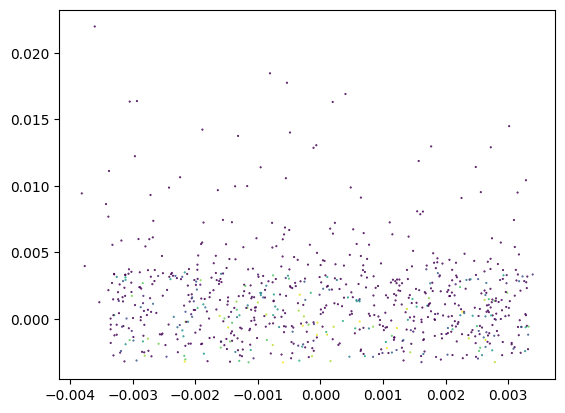

In [46]:
plt.scatter(data[:,0],data[:,1],marker='.',s=1,c=clusterization.labels_)
plt.show()

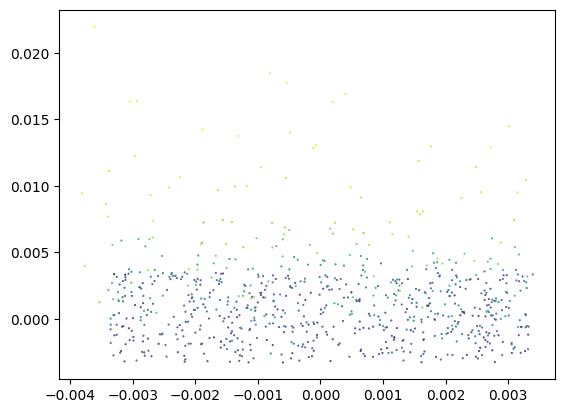

In [47]:
plt.scatter(data[:,0],data[:,1],marker='.',s=1,c=clusterization.weights_)
plt.show()

In [48]:
labels = clusterization.labels_

In [50]:
from collections import defaultdict

cluster_words = defaultdict(list)
for word, label in zip(word2vec_vectors.keys(), labels):
    if label == 0:
        continue
    cluster_words[label].append(word)

In [52]:
with open("clusters/clusters_w2v_test.txt", "w", encoding="utf-8") as f:
    for cluster_id, words in cluster_words.items():
        f.write(f"Cluster {cluster_id}:\n")
        f.write(", ".join(sorted(words)) + "\n\n")

Кластеризация по словосочетаниям

In [1]:
from gudhi.clustering.tomato import Tomato
from scipy.spatial.distance import cosine
from collections import defaultdict
import os
import numpy as np
from tqdm import tqdm

In [4]:
def cluster_and_save(data, k, output_dir="clusters"):
    os.makedirs(output_dir, exist_ok=True)
    
    for adj in tqdm(data.keys()):
        for model_name in ['initial', 'wor2vec', 'fasttext', 'tf_idf', 'stock_bert', 'finetuned_bert']:
            vectors = []
            words = []

            for noun, models in data[adj].items():
                vector = models.get(model_name)
                if vector is not None and not np.allclose(vector, 0):
                    vectors.append(vector)
                    words.append(noun)
                
            try:
                clusterization = Tomato(
                    metric=cosine, 
                    density_type='logKDE', 
                    k=k, 
                    kde_params={'algorithm': 'ball_tree', 'metric': 'pyfunc', 'metric_params': {'func': cosine}}
                )

                clusterization.fit(vectors)
                labels = clusterization.labels_
                
                cluster_words = defaultdict(list)
                for word, label in zip(words, labels):
                    if label == -1:
                        continue
                    cluster_words[label].append(word)
                
                filename = f"{output_dir}/{adj}_{model_name}_clusters.txt"
                with open(filename, "w", encoding="utf-8") as f:
                    f.write(f"Number of clusters: {len(cluster_words)}\n\n")
                    for cluster_id, words in cluster_words.items():
                        f.write(f"### Cluster {cluster_id} ({len(words)} words)\n")
                        f.write(", ".join(sorted(words))) 
                        f.write("\n\n")        
            except Exception as e:
                print(f"Ошибка для {adj}-{model_name}: {str(e)}")

In [7]:
import pickle

with open("data/embeddings_dict.pkl", "rb") as f:
    data = pickle.load(f)

cluster_and_save(data, 4)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [06:09<00:00,  3.73s/it]


KDE:

При k = 2, 3. 1 кластер на все слова

При k = 4, 5, 6, 7. 1 большой кластер, остальные по 1 слову в кластере

logKDE:

Все аналогично

При k = 2, 3. 1 кластер